<a href="https://colab.research.google.com/github/Shreyans145/Project_1-Lusip/blob/master/finalproject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install shap


     |████████████████████████████████| 276kB 4.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394111 sha256=87c1e6c848a0b317f733cb032a83e5d0849d6ae94ba93dbafa68f46ed7cc82d5
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [ ]:
pip install numpy

In [ ]:
pip install mpl_finance

In [ ]:
#importing all the library
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
import time
import shap
import math
import datetime as dt

from keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense,LSTM

print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)


Using TensorFlow backend.


Numpy version: 1.18.5
Pandas version: 1.0.5
Matplotlib version: 3.2.2
Sklearn version: 0.22.2.post1
Keras version: 2.3.1


In [ ]:
# import the dataset of OPEN , HIGH, LOW, CLOSE prices from github which has been uploded previously
url = 'https://raw.githubusercontent.com/viveknunia/hello-world/master/tesla.csv'
my_dataset = pd.read_csv(url)
print(my_dataset)

            Open        High         Low       Close
0      19.000000   25.000000   17.540001   23.889999
1      25.790001   30.420000   23.299999   23.830000
2      25.000000   25.920000   20.270000   21.959999
3      23.000000   23.100000   18.709999   19.200001
4      20.000000   20.000000   15.830000   16.110001
...          ...         ...         ...         ...
1635  208.000000  213.449997  207.710007  213.339996
1636  214.880005  222.250000  214.419998  219.529999
1637  221.529999  223.800003  217.199997  219.740006
1638  218.559998  219.199997  214.119995  214.679993
1639  216.300003  217.500000  211.679993  213.690002

[1640 rows x 4 columns]


In [ ]:
# function to plot candlestick_ohlc dataset
def graph_data_ohlc(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1),(0,0))
    closep = dataset[:,[3]]
    openp = dataset[:,[0]]
    highp = dataset[:,[1]]
    lowp = dataset[:,[2]]
    date = range(len(closep))
    
    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x] , openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x += 1
    candlestick_ohlc(ax1, ohlc, width = 0.3, colorup='#77d879', colordown='#db3f3f')
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))

    ax1.grid(True)
    plt.xlabel('Candel')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

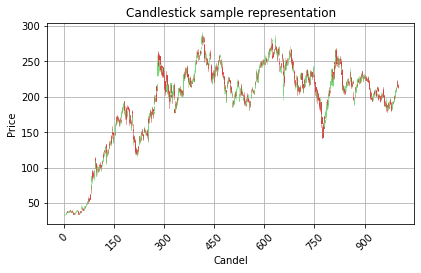

In [ ]:
graph_data_ohlc(my_dataset.tail(1000).values)

In [ ]:
# function to get the numeber of rows to train the model
def data_len_func(data):
    dataset = data.values
    training_data_len = math.ceil(len(dataset)*.8)
    return training_data_len

In [ ]:
# getting the length of close , open,high,low data for training

close_training_data_len = data_len_func(my_dataset.filter(['Close']))
open_training_data_len = data_len_func(my_dataset.filter(['Open']))
high_training_data_len = data_len_func(my_dataset.filter(['High']))
low_training_data_len = data_len_func(my_dataset.filter(['Low']))


In [ ]:
# getting the scaled data of close,open,high,low 
data = my_dataset.filter(['Close'])
dataset = data.values
close_scaler = MinMaxScaler(feature_range= (0,1))
close_scaled_data = close_scaler.fit_transform(dataset)

data = my_dataset.filter(['High'])
dataset = data.values
high_scaler = MinMaxScaler(feature_range= (0,1))
high_scaled_data = high_scaler.fit_transform(dataset)


data = my_dataset.filter(['Open'])
dataset = data.values
open_scaler = MinMaxScaler(feature_range= (0,1))
open_scaled_data = open_scaler.fit_transform(dataset)


data = my_dataset.filter(['Low'])
dataset = data.values
low_scaler = MinMaxScaler(feature_range= (0,1))
low_scaled_data = low_scaler.fit_transform(dataset)



In [ ]:
#create the training dataset func
def create_train_dataset_fun(scaled_data,training_data_len):
    train_data = scaled_data[0:training_data_len,:]
    x_train = []
    y_train = []
    for i in range(60,len(train_data)):
        x_train.append(train_data[i-60:i,0])
        y_train.append(train_data[i,0])
    return x_train,y_train

In [ ]:
# get the traing dataset for close,open,high,low
close_x_train, close_y_train = create_train_dataset_fun(close_scaled_data,close_training_data_len)
open_x_train, open_y_train = create_train_dataset_fun(open_scaled_data,open_training_data_len)
high_x_train, high_y_train = create_train_dataset_fun(high_scaled_data,high_training_data_len)
low_x_train, low_y_train = create_train_dataset_fun(low_scaled_data,low_training_data_len)


In [ ]:
# convert all the x_train and y_train into numpy arrays
close_x_train,close_y_train = np.array(close_x_train),np.array(close_y_train)
open_x_train,open_y_train = np.array(open_x_train),np.array(open_y_train)
high_x_train,high_y_train = np.array(high_x_train),np.array(high_y_train)
low_x_train,low_y_train = np.array(low_x_train),np.array(low_y_train)

In [ ]:
#reshape the data in 3D
close_x_train = np.reshape(close_x_train, (close_x_train.shape[0],close_x_train.shape[1],1))
open_x_train = np.reshape(open_x_train, ( open_x_train.shape[0],open_x_train.shape[1],1))
high_x_train = np.reshape(high_x_train, (high_x_train.shape[0],high_x_train.shape[1],1))
low_x_train = np.reshape(low_x_train, (low_x_train.shape[0],low_x_train.shape[1],1))
close_x_train.shape

(1252, 60, 1)

In [ ]:
#build the model for close
close_model = Sequential()
close_model.add(LSTM(50,return_sequences=True,input_shape = (close_x_train.shape[1],1)))
close_model.add(LSTM(50,return_sequences= False))
close_model.add(Dense(25))
close_model.add(Dense(1))

close_model.compile(optimizer = 'adam',loss = 'mean_squared_error')

#build the model for high
high_model = Sequential()
high_model.add(LSTM(50,return_sequences=True,input_shape = (high_x_train.shape[1],1)))
high_model.add(LSTM(50,return_sequences= False))
high_model.add(Dense(25))
high_model.add(Dense(1))

high_model.compile(optimizer = 'adam',loss = 'mean_squared_error')

#build the model for low

low_model = Sequential()
low_model.add(LSTM(50,return_sequences=True,input_shape = (low_x_train.shape[1],1)))
low_model.add(LSTM(50,return_sequences= False))
low_model.add(Dense(25))
low_model.add(Dense(1))

low_model.compile(optimizer = 'adam',loss = 'mean_squared_error')


#build the model for open

open_model = Sequential()
open_model.add(LSTM(50,return_sequences=True,input_shape = (open_x_train.shape[1],1)))
open_model.add(LSTM(50,return_sequences= False))
open_model.add(Dense(25))
open_model.add(Dense(1))

open_model.compile(optimizer = 'adam',loss = 'mean_squared_error')


In [ ]:
print("close_model")
print("\n")
close_model.summary()
print("\n")
print("open_model")
print("\n")
open_model.summary()
print("\n")
print("high_model")
print("\n")
high_model.summary()
print("\n")
print("low_model")
print("\n")
low_model.summary()

close_model


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


open_model


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 60, 50)            10400     

In [ ]:
#train the model
close_model.fit(close_x_train,close_y_train,batch_size=1,epochs=30)
open_model.fit(open_x_train,open_y_train,batch_size=1,epochs=30)
high_model.fit(high_x_train,high_y_train,batch_size=1,epochs=30)
low_model.fit(low_x_train,low_y_train,batch_size=1,epochs=30)


Epoch 1/30
1252/1252 [==============================] - 51s 41ms/step - loss: 0.0030
Epoch 2/30
1252/1252 [==============================] - 49s 39ms/step - loss: 0.0012
Epoch 3/30
1252/1252 [==============================] - 49s 39ms/step - loss: 0.0013
Epoch 4/30
1252/1252 [==============================] - 49s 39ms/step - loss: 8.0673e-04
Epoch 5/30
1252/1252 [==============================] - 49s 39ms/step - loss: 6.5310e-04
Epoch 6/30
1252/1252 [==============================] - 48s 39ms/step - loss: 5.5508e-04
Epoch 7/30
1252/1252 [==============================] - 48s 39ms/step - loss: 6.6737e-04
Epoch 8/30
1252/1252 [==============================] - 49s 39ms/step - loss: 5.1952e-04
Epoch 9/30
1252/1252 [==============================] - 48s 39ms/step - loss: 5.2507e-04
Epoch 10/30
1252/1252 [==============================] - 49s 39ms/step - loss: 5.8876e-04
Epoch 11/30
1252/1252 [==============================] - 48s 38ms/step - loss: 4.6766e-04
Epoch 12/30
1252/1252 [========

In [ ]:
# create the test dataset func
def create_test_dataset_func(scaled_data,training_data_len,data):
    dataset = data.values
    test_data = scaled_data[training_data_len - 60: ,:]
    x_test = []
    y_test = dataset[training_data_len : , :]
    for i in range(60,len(test_data)):
        x_test.append(test_data[i-60:i,0])

    return x_test


In [ ]:
# get the test data
close_x_test = create_test_dataset_func(close_scaled_data,close_training_data_len,my_dataset.filter(['Close']))
high_x_test = create_test_dataset_func(high_scaled_data,high_training_data_len,my_dataset.filter(['High']))
low_x_test = create_test_dataset_func(low_scaled_data,low_training_data_len,my_dataset.filter(['Low']))
open_x_test = create_test_dataset_func(open_scaled_data,open_training_data_len,my_dataset.filter(['Open']))

In [ ]:

#convert the data into numpy arrays
close_x_test = np.array(close_x_test)
cl = close_x_test
open_x_test = np.array(open_x_test)
ope = open_x_test
high_x_test = np.array(high_x_test)
hi = high_x_test
low_x_test = np.array(low_x_test)
lo = low_x_test

In [ ]:
#reshape the data
close_x_test = np.reshape(close_x_test,(close_x_test.shape[0],close_x_test.shape[1],1))
high_x_test = np.reshape(high_x_test,(high_x_test.shape[0],high_x_test.shape[1],1))
open_x_test = np.reshape(open_x_test,(open_x_test.shape[0],open_x_test.shape[1],1))
low_x_test = np.reshape(low_x_test,(low_x_test.shape[0],low_x_test.shape[1],1))

In [ ]:
# get the model pridicted values

close_predictions = close_model.predict(close_x_test) 
close_predictions = close_scaler.inverse_transform(close_predictions)

high_predictions = high_model.predict(high_x_test) 
high_predictions = high_scaler.inverse_transform(high_predictions)

open_predictions = open_model.predict(open_x_test) 
open_predictions = open_scaler.inverse_transform(open_predictions)

low_predictions = low_model.predict(low_x_test) 
low_predictions = low_scaler.inverse_transform(low_predictions)
low_predictions

array([[248.32147],
       [247.36314],
       [251.4492 ],
       [259.1459 ],
       [254.15175],
       [253.32864],
       [253.19952],
       [255.35918],
       [253.60449],
       [253.9619 ],
       [243.41953],
       [244.00798],
       [240.35727],
       [235.71373],
       [233.9419 ],
       [244.3404 ],
       [233.23918],
       [228.21002],
       [219.74976],
       [217.90852],
       [214.9428 ],
       [211.09695],
       [216.13336],
       [213.48386],
       [224.00307],
       [224.29967],
       [199.9324 ],
       [209.23529],
       [208.69582],
       [208.14375],
       [210.33493],
       [207.1541 ],
       [208.36113],
       [210.5726 ],
       [203.12215],
       [207.56729],
       [207.40909],
       [227.25061],
       [228.2804 ],
       [228.74048],
       [222.18867],
       [214.28949],
       [212.69261],
       [212.22086],
       [206.10553],
       [206.06085],
       [212.0033 ],
       [212.62067],
       [221.0998 ],
       [212.10619],


In [ ]:
close_train = my_dataset.filter(['Close'])[:close_training_data_len] 
close_valid = my_dataset.filter(['Close'])[close_training_data_len:]
close_valid['Predictions'] = close_predictions

high_train = my_dataset.filter(['High'])[:high_training_data_len] 
high_valid = my_dataset.filter(['High'])[high_training_data_len:]
high_valid['Predictions'] = high_predictions

low_train = my_dataset.filter(['Low'])[:low_training_data_len] 
low_valid = my_dataset.filter(['Low'])[low_training_data_len:]
low_valid['Predictions'] = low_predictions

open_train = my_dataset.filter(['Open'])[:open_training_data_len] 
open_valid = my_dataset.filter(['Open'])[open_training_data_len:]
open_valid['Predictions'] = open_predictions

In [ ]:
close_predictions = close_predictions.flatten()

In [ ]:
low_predictions = low_predictions.flatten()

In [ ]:
high_predictions = high_predictions.flatten()

In [ ]:
open_predictions = open_predictions.flatten()

In [ ]:
predicted_df = pd.DataFrame(data = [open_predictions,high_predictions,low_predictions,close_predictions])

In [ ]:
predicted_T = predicted_df.T

In [ ]:
predicted_T =predicted_T.rename(columns = {0:'Open',1:'High',2:'Low',3:'Close'})

In [ ]:
predicted_T

,Open,High,Low,Close
0,250.791702,259.569794,248.321472,255.927002
1,252.203430,258.937164,247.363144,256.149902
2,252.593216,269.213257,251.449203,265.188416
3,262.825439,269.327271,259.145905,264.498779
4,256.735535,267.696289,254.151749,262.699310
...,...,...,...,...
323,208.943085,213.707199,205.923279,211.382950
324,208.957520,218.777267,207.480438,216.485321
325,215.277420,228.033234,214.459839,222.917404
326,221.627670,227.829819,216.745071,222.862244


In [ ]:
my_dataset.tail(328)

,Open,High,Low,Close
1312,252.750000,254.600006,249.500000,253.570007
1313,253.039993,262.880005,252.880005,262.250000
1314,263.959992,265.500000,260.690002,262.070007
1315,257.959992,263.820007,257.500000,260.619995
1316,263.980011,271.570007,255.800003,264.200012
...,...,...,...,...
1635,208.000000,213.449997,207.710007,213.339996
1636,214.880005,222.250000,214.419998,219.529999
1637,221.529999,223.800003,217.199997,219.740006
1638,218.559998,219.199997,214.119995,214.679993


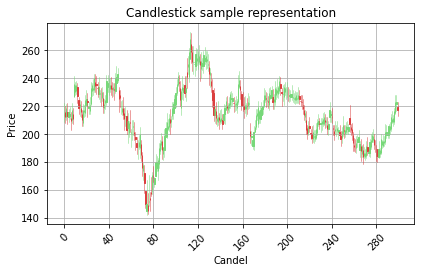

In [ ]:
graph_data_ohlc(predicted_T.tail(300).values)

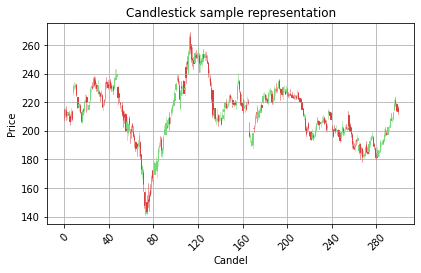

In [ ]:
graph_data_ohlc(my_dataset.tail(300).values)